In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

In [2]:
class PotholeDetector:
    def __init__(self, model_path='final_pothole_detection_model.h5'):
        # Class names matching the detection task
        self.class_names = ['Normal Road', 'Pothole']
        
        # Load the pre-trained model
        print("Loading model...")
        self.model = tf.keras.models.load_model(model_path)
        print(f"Model loaded successfully! Available classes: {self.class_names}")

        # Initialize webcam index
        self.camera_index = 0
        self.current_frame = None

    def preprocess_image(self, img, target_size=(224, 224)):
        """Preprocess a single image for prediction."""
        if isinstance(img, str):  # If input is image path
            img = cv2.imread(img)
            if img is None:
                raise ValueError(f"Could not load image: {img}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img = cv2.resize(img, target_size)
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=0)
        return img

    def predict_image(self, preprocessed_img):
        """Make prediction on the preprocessed image."""
        prediction = self.model.predict(preprocessed_img, verbose=0)
        class_idx = 0 if prediction[0][0] < 0.5 else 1
        confidence = prediction[0][0] if class_idx == 1 else 1 - prediction[0][0]
        return self.class_names[class_idx], confidence

    def start_webcam(self):
        """Start webcam detection with Tkinter GUI."""
        # Create Tkinter window
        root = tk.Tk()
        root.title("Pothole Detection")
        
        # Create matplotlib figure
        fig, ax = plt.subplots(figsize=(10, 8))
        canvas = FigureCanvasTkAgg(fig, master=root)
        canvas_widget = canvas.get_tk_widget()
        canvas_widget.pack()

        # Add control buttons
        button_frame = tk.Frame(root)
        button_frame.pack(pady=10)

        def save_frame():
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"pothole_capture_{timestamp}.jpg"
            if self.current_frame is not None:
                cv2.imwrite(filename, cv2.cvtColor(self.current_frame, cv2.COLOR_RGB2BGR))
                print(f"Frame saved as {filename}")

        save_button = tk.Button(button_frame, text="Save Frame", command=save_frame)
        save_button.pack(side=tk.LEFT, padx=5)

        quit_button = tk.Button(button_frame, text="Quit", command=root.quit)
        quit_button.pack(side=tk.LEFT, padx=5)

        status_label = tk.Label(root, text="", wraplength=400)
        status_label.pack(pady=5)

        # Initialize camera
        cap = cv2.VideoCapture(self.camera_index)
        if not cap.isOpened():
            status_label.config(text="Error: Could not open webcam. Please check your camera connection.")
            root.update()
            return

        def update_frame():
            ret, frame = cap.read()
            if ret:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                self.current_frame = frame_rgb

                # Preprocess frame
                processed_frame = self.preprocess_image(frame)

                # Get prediction
                class_label, confidence = self.predict_image(processed_frame)

                # Display image
                ax.clear()
                ax.imshow(frame_rgb)

                # Add prediction text
                text = f'{class_label}: {confidence:.2%}'
                color = (0, 255, 0) if class_label == "Normal Road" else (0, 0, 255)
                ax.text(10, 30, text, color='white', fontsize=12,
                        bbox=dict(facecolor='black', alpha=0.7))

                ax.axis('off')
                canvas.draw()

                # Update status
                status_label.config(text="Running - Press 'Save Frame' to capture or 'Quit' to exit")

            # Schedule the next update
            if root.winfo_exists():
                root.after(50, update_frame)

        # Start the update loop
        update_frame()

        try:
            root.mainloop()
        finally:
            cap.release()
            plt.close(fig)
            root.destroy()

    def predict_single_image(self):
        """Predict pothole from a single image file."""
        file_path = input("Enter the full path to the image file: ")

        if not file_path:
            print("No file selected")
            return

        try:
            image = cv2.imread(file_path)
            if image is None:
                print("Error: Could not read the image file")
                return

            original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Preprocess image
            processed_image = self.preprocess_image(image)

            # Get prediction
            class_label, confidence = self.predict_image(processed_image)

            # Display results
            plt.figure(figsize=(8, 6))
            plt.imshow(original_image)
            plt.title(f'Prediction: {class_label}\nConfidence: {confidence:.2%}')
            plt.axis('off')
            plt.show()

            print(f"\nResults for {os.path.basename(file_path)}:")
            print(f"Prediction: {class_label}")
            print(f"Confidence: {confidence:.2%}")

        except Exception as e:
            print(f"Error processing image: {str(e)}")

    def display_menu(self):
        """Display the main menu."""
        print("\n=== Pothole Detection System ===")
        print("1. Start Webcam Detection")
        print("2. Predict Single Image")
        print("3. Exit")
        print("=============================")
        return input("Enter your choice (1-3): ")

In [3]:
def main():
    """Main function with menu-driven interface."""
    detector = PotholeDetector()

    while True:
        choice = detector.display_menu()

        if choice == "1":
            detector.start_webcam()
        elif choice == "2":
            detector.predict_single_image()
        elif choice == "3":
            print("\nThank you for using Pothole Detection System!")
            break
        else:
            print("\nInvalid choice! Please enter a number between 1 and 3.")

Loading model...
Model loaded successfully! Available classes: ['Normal Road', 'Pothole']

=== Pothole Detection System ===
1. Start Webcam Detection
2. Predict Single Image
3. Exit


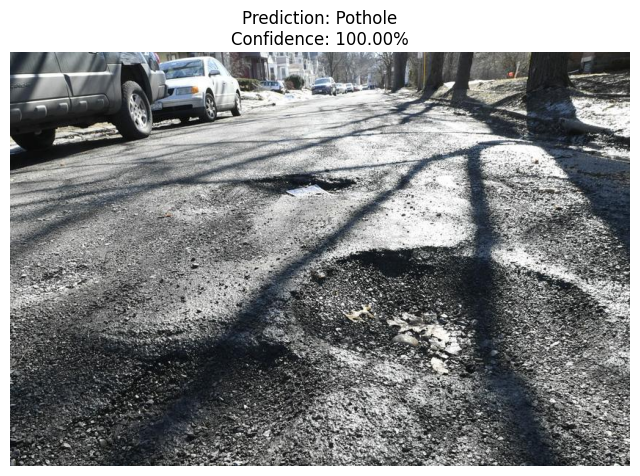


Results for 283.jpg:
Prediction: Pothole
Confidence: 100.00%

=== Pothole Detection System ===
1. Start Webcam Detection
2. Predict Single Image
3. Exit

Invalid choice! Please enter a number between 1 and 3.

=== Pothole Detection System ===
1. Start Webcam Detection
2. Predict Single Image
3. Exit

Thank you for using Pothole Detection System!


In [4]:
if __name__ == "__main__":
    main()